# Relax Inc Take Home Challenge

Here is the requirement: Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

There are two tables, a user table and a usage table. Beacuse we're trying to find out which factors predict future user adoption, this is an unsupervised learning question that will mostly require the user table but filtered by the "adopted user" criteria on the usage table. 

Of the features that might be important are: creation source, creation time, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, and invited_by_user_id. It would be interesting if there was a correlation between adopted user and an individual user's invitation. My guess is that org_id and a certain type of creation_source will be influential features.  For classification problems, I can use random forests or KNN. 

Let's take a look at the data first and check for duplicates and null values.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

users = pd.read_csv('takehome_users.csv', encoding='latin-1')
usage = pd.read_csv('takehome_user_engagement.csv')

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [13]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [19]:
#I want to check if the usage table is in numerical order of user_id

usage[usage['user_id']==200]

,time_stamp,user_id,visited
3375,2013-02-25 12:41:33,200,1
3376,2013-03-14 12:41:33,200,1
3377,2013-04-03 12:41:33,200,1
3378,2013-04-06 12:41:33,200,1
3379,2013-04-08 12:41:33,200,1
...,...,...,...
3529,2014-05-27 12:41:33,200,1
3530,2014-05-28 12:41:33,200,1
3531,2014-05-31 12:41:33,200,1
3532,2014-06-01 12:41:33,200,1


In [28]:
#Looks like it is

#I need to convert the time_stamp column into a datetime 

usage['time_stamp']=pd.to_datetime(usage['time_stamp'])

usage['date'] = usage['time_stamp'].dt.date


In [35]:
usage.head(20)

,time_stamp,user_id,visited,rolling_window,date
0,2014-04-22 03:53:30,1,1,0,2014-04-22
1,2013-11-15 03:45:04,2,1,0,2013-11-15
2,2013-11-29 03:45:04,2,1,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2,2013-12-09
4,2013-12-25 03:45:04,2,1,3,2013-12-25
5,2013-12-31 03:45:04,2,1,3,2013-12-31
6,2014-01-08 03:45:04,2,1,4,2014-01-08
7,2014-02-03 03:45:04,2,1,5,2014-02-03
8,2014-02-08 03:45:04,2,1,5,2014-02-08
9,2014-02-09 03:45:04,2,1,5,2014-02-09


In [42]:
#I want to create a rolling window of 7 days and see which users
#have visited more than 3 times in that window

usage['rolling_sum'] = usage.groupby('user_id')['visit_count'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)


filtered_result = usage[usage['rolling_sum'] >= 3]['user_id'].unique()


In [44]:
filtered_user_info = users[users['object_id'].isin(filtered_result)]

In [45]:
filtered_user_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [46]:
filtered_user_info.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [52]:
filtered_user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 1 to 11990
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   2248 non-null   int64  
 1   creation_time               2248 non-null   object 
 2   name                        2248 non-null   object 
 3   email                       2248 non-null   object 
 4   creation_source             2248 non-null   object 
 5   last_session_creation_time  2248 non-null   float64
 6   opted_in_to_mailing_list    2248 non-null   int64  
 7   enabled_for_marketing_drip  2248 non-null   int64  
 8   org_id                      2248 non-null   int64  
 9   invited_by_user_id          1285 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 193.2+ KB


In [55]:
users['adopted'] = users['object_id'].isin(filtered_user_info['object_id']).astype(int)

In [56]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [57]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

In [58]:
cols_drop = ['object_id', 'name', 'email']

users_drop = users.drop(columns=cols_drop)

In [62]:
users_drop  = pd.get_dummies(users_drop, columns=['creation_source'], prefix='cs')

In [68]:
nan_count_per_column = users_drop.isnull().sum()

# Display the count of NaN values in each column
print("Count of NaN values in each column:")
print(nan_count_per_column)


Count of NaN values in each column:
creation_time                    0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
cs_GUEST_INVITE                  0
cs_ORG_INVITE                    0
cs_PERSONAL_PROJECTS             0
cs_SIGNUP                        0
cs_SIGNUP_GOOGLE_AUTH            0
dtype: int64


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

features_for_prediction = users_drop.drop(columns=['creation_time','last_session_creation_time','invited_by_user_id','adopted'])


target_variable = users_drop['adopted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_for_prediction, target_variable, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.815
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1956
           1       1.00      0.00      0.00       444

    accuracy                           0.81      2400
   macro avg       0.91      0.50      0.45      2400
weighted avg       0.85      0.81      0.73      2400



This is just a simple logisitc regression for the adoption classification and it went terribly! I do not trust this model for finding the adopted users.

In [71]:
feature_importances = model.coef_[0]

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features_for_prediction.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

                      Feature  Importance
0    opted_in_to_mailing_list    0.030122
1  enabled_for_marketing_drip    0.026807
2                      org_id    0.001592
3             cs_GUEST_INVITE   -0.016265
7       cs_SIGNUP_GOOGLE_AUTH   -0.059194
6                   cs_SIGNUP   -0.154200
4               cs_ORG_INVITE   -0.304785
5        cs_PERSONAL_PROJECTS   -0.887730


These are not great numbers. If were to keep going with this project, I'd try and find a better model to see which feature is most correlated to adoption. But for now, I'll leave you with a heat map.

/var/folders/2s/11ldfx_j2c9237b89l98fmdr0000gn/T/ipykernel_89652/992962328.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = users_drop.corr()


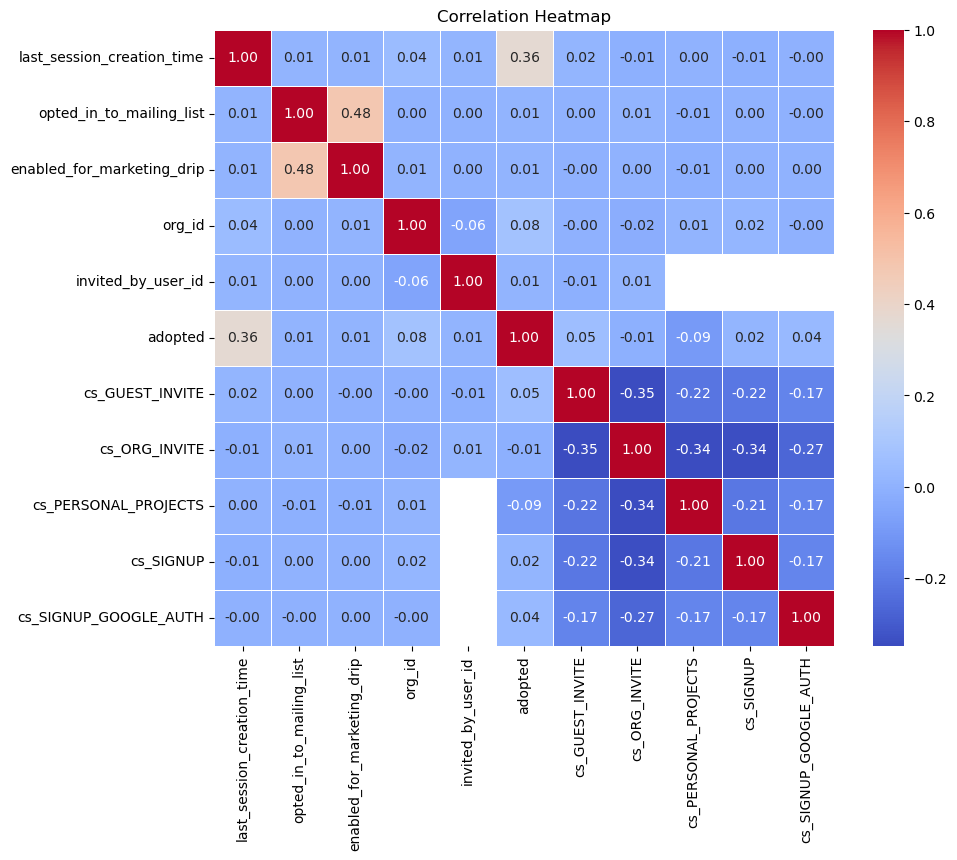

In [72]:
import seaborn as sns

correlation_matrix = users_drop.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()